# Hedonic Pricing

We often try to predict the price of an asset from its observable characteristics. This is generally called **hedonic pricing**: How do the unit's characteristics determine its market price?

In the lab folder, there are three options: housing prices in pierce_county_house_sales.csv, car prices in cars_hw.csv, and airbnb rental prices in airbnb_hw.csv. If you know of another suitable dataset, please feel free to use that one.

1. Clean the data and perform some EDA and visualization to get to know the data set.
2. Transform your variables --- particularly categorical ones --- for use in your regression analysis.
3. Implement an ~80/~20 train-test split. Put the test data aside.
4. Build some simple linear models that include no transformations or interactions. Fit them, and determine their RMSE and $R^2$ on the both the training and test sets. Which of your models does the best?
5. Include transformations and interactions, and build a more complex model that reflects your ideas about how the features of the asset determine its value. Determine its RMSE and $R^2$ on the training and test sets. How does the more complex model your build compare to the simpler ones?
6. Summarize your results from 1 to 5. Have you learned anything about overfitting and underfitting, or model selection?
7. If you have time, use the sklearn.linear_model.Lasso to regularize your model and select the most predictive features. Which does it select? What are the RMSE and $R^2$? We'll cover the Lasso later in detail in class.



In [35]:
! git clone https://github.com/DS3001/labs


fatal: destination path 'labs' already exists and is not an empty directory.


,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000.0
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000.0
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000.0
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000.0
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000.0


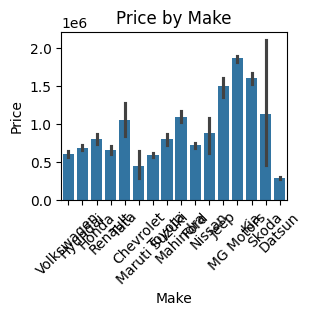

In [60]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv("/content/labs/04_hedonic_pricing/cars_hw.csv")

df = df.dropna()
df['Price'] = df['Price'].astype(float)
df['Make_Year'] = df['Make_Year'].astype(int)
df['Mileage_Run'] = df['Mileage_Run'].astype(int)
df.head()
plt.subplot(2, 2, 1)
sns.barplot(data=df, x='Make', y='Price')
plt.title('Price by Make')
plt.xticks(rotation=45)
df.head()




Text(0.5, 1.0, 'Price vs Mileage')

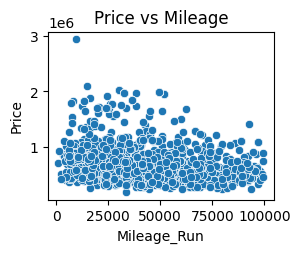

In [55]:
plt.subplot(2, 2, 2)
sns.scatterplot(data=df, x='Mileage_Run', y='Price')
plt.title('Price vs Mileage')

In [57]:

X = df[['Make_Year', 'Mileage_Run']]
y = df['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [66]:
feature_sets = {
    'Model 1 (Year only)': ['Make_Year'],
    'Model 2 (Mileage only)': ['Mileage_Run'],
    'Model 3 (Year + Mileage)': ['Make_Year', 'Mileage_Run']
}

for model_name, features in feature_sets.items():

    X = df[features]
    y = df['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    model = LinearRegression()
    model.fit(X_train_scaled, y_train)

    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)

    results[model_name] = {
        'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'Train R2': r2_score(y_train, y_train_pred),
        'Test R2': r2_score(y_test, y_test_pred)
    }
results_df = pd.DataFrame(results).T
print(results_df)

                             Train RMSE  Train R2      Test RMSE   Test R2
Make_Year                 317443.710381  0.278048  288232.563579  0.275664
Mileage_Run               369437.232061  0.022186  330349.982458  0.048514
Model 1 (Year only)       317443.710381  0.278048  288232.563579  0.275664
Model 2 (Mileage only)    369437.232061  0.022186  330349.982458  0.048514
Model 3 (Year + Mileage)  310695.036967  0.308418  283873.728209  0.297407


It seems that the best model when using a simple linear regression is the third model which looks at both the year and mileage.

In [63]:
current_year = 2024
df['Age'] = current_year - df['Make_Year']

df['Miles_Per_Year'] = df['Mileage_Run'] / df['Age']

numeric_features = ['Make_Year', 'Mileage_Run', 'Age', 'Miles_Per_Year']
categorical_features = ['Make', 'Transmission', 'Fuel_Type']
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X = df[numeric_features + categorical_features]
y = df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_transformed)
X_test_poly = poly.transform(X_test_transformed)
complex_model = LinearRegression()
complex_model.fit(X_train_poly, y_train)
y_train_pred_complex = complex_model.predict(X_train_poly)
y_test_pred_complex = complex_model.predict(X_test_poly)
complex_results = {
    'Train RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred_complex)),
    'Test RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred_complex)),
    'Train R2': r2_score(y_train, y_train_pred_complex),
    'Test R2': r2_score(y_test, y_test_pred_complex)
}
print(complex_results)

{'Train RMSE': 134845.93866795476, 'Test RMSE': 171703.72602237802, 'Train R2': 0.8697281171098643, 'Test R2': 0.7429526528386079}


It seems that the simple model underfit the data making it less accurate. Furthermore the model itself could lead to the data having better or worse predictions. When accounting for all the aspects of a car the model worked better than when it only looked at the Year and Mileage.